# Proyek Klasifikasi Gambar: [Plant Disease]
- **Nama:** [Muhammad Yazid Hakim]
- **Email:** [yazhaofficial@gmail.com]
- **ID Dicoding:** [yazidhakim]

## Import Semua Packages/Library yang Digunakan

In [ ]:
pip show tensorflow

Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


In [2]:
pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.9.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [3]:
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import tensorflowjs as tfjs


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

In [5]:
SEED = 59
IMG_SIZE = 224
BATCH = 32
DATA_DIR = "/content/drive/MyDrive/plant leaf disease.v1i.multiclass"

### Data Loading

In [6]:
train_df = pd.read_csv(os.path.join(DATA_DIR, "train/_classes.csv"))
val_df   = pd.read_csv(os.path.join(DATA_DIR, "valid/_classes.csv"))
test_df  = pd.read_csv(os.path.join(DATA_DIR, "test/_classes.csv"))

print(train_df.head())
print(val_df.head())
print(test_df.head())


                                            filename  Yellow_Leaf_Curl_Virus  \
0  image-251-_JPG.rf.c244ebf58fd005df4b772dabdb76...                       1   
1  image-1082-_JPG.rf.9dd25ce65ac5ee934284eb77424...                       0   
2  image-254-_JPG.rf.408ba84fcfcb39aa75b5133de1de...                       0   
3  image-248-_JPG.rf.749aba2c447693d1220513a3e642...                       0   
4  image-249-_JPG.rf.ea3d7f5882316a9c49125834ebf3...                       0   

   black_measles  healthy  leaf_sorch  mildew  scab  
0              0        0           0       0     0  
1              0        0           1       0     0  
2              0        0           0       1     0  
3              0        0           0       1     0  
4              0        0           0       0     1  
                                            filename  Yellow_Leaf_Curl_Virus  \
0  image-203-_JPG.rf.1274acd498863843690c1dae9acc...                       0   
1  image-1040-_JPG.rf.f903e71aef616

### Data Preprocessing

In [7]:
train_df = train_df.melt(id_vars=["filename"], var_name="class", value_name="val")
train_df = train_df[train_df["val"]==1][["filename","class"]]

val_df = val_df.melt(id_vars=["filename"], var_name="class", value_name="val")
val_df = val_df[val_df["val"]==1][["filename","class"]]

test_df = test_df.melt(id_vars=["filename"], var_name="class", value_name="val")
test_df = test_df[test_df["val"]==1][["filename","class"]]


In [8]:
# ambil daftar semua kelas dari train/val/test
all_classes = sorted(
    list(set(train_df['class'].unique())
        | set(val_df['class'].unique())
        | set(test_df['class'].unique()))
)

print("Daftar kelas:", all_classes)
print("Jumlah kelas:", len(all_classes))


Daftar kelas: ['Yellow_Leaf_Curl_Virus', 'black_measles', 'healthy', 'leaf_sorch', 'mildew', 'scab']
Jumlah kelas: 6


In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

#### Split Dataset

In [43]:
# Ambil semua file dan label dari dataset
all_image_paths = train_df['filename'].values
all_labels = train_df['class'].values

# Split menjadi train+val (90%) dan test (10%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    all_image_paths, all_labels, test_size=0.10, random_state=42, stratify=all_labels
)

# Split train+val menjadi train (80/90 ≈ 88.89%) dan val (10/90 ≈ 11.11%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1111, random_state=42, stratify=y_train_val
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 1661, Val: 208, Test: 208


In [44]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_train, 'class': y_train}),
    directory=os.path.join(DATA_DIR, "train"),
    x_col="filename",
    y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="categorical",
    classes=all_classes,
    batch_size=BATCH,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_val, 'class': y_val}),
    directory=os.path.join(DATA_DIR, "train"),
    x_col="filename",
    y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="categorical",
    classes=all_classes,
    batch_size=BATCH,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_test, 'class': y_test}),
    directory=os.path.join(DATA_DIR, "train"),
    x_col="filename",
    y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="categorical",
    classes=all_classes,
    batch_size=BATCH,
    shuffle=False
)


print("Classes:", train_generator.class_indices)



Found 1661 validated image filenames belonging to 6 classes.
Found 208 validated image filenames belonging to 6 classes.
Found 208 validated image filenames belonging to 6 classes.
Classes: {'Yellow_Leaf_Curl_Virus': 0, 'black_measles': 1, 'healthy': 2, 'leaf_sorch': 3, 'mildew': 4, 'scab': 5}


## Modelling

In [45]:
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
num_classes = len(class_indices)

In [46]:
model = keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(32, 3, padding="same", use_bias=False),
    layers.BatchNormalization(), layers.ReLU(),
    layers.MaxPooling2D(), layers.Dropout(0.2),

    layers.Conv2D(64, 3, padding="same", use_bias=False),
    layers.BatchNormalization(), layers.ReLU(),
    layers.MaxPooling2D(), layers.Dropout(0.25),

    layers.Conv2D(128, 3, padding="same", use_bias=False),
    layers.BatchNormalization(), layers.ReLU(),
    layers.MaxPooling2D(), layers.Dropout(0.3),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation="softmax"),
], name="BaselineCNN")

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("best.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
]

history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=20,
                    callbacks=callbacks)

Model: "BaselineCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 224, 224, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,206 (434.40 KB)

 Trainable params: 110,758 (432.65 KB)

 Non-trainable params: 448 (1.75 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4844 - loss: 1.4945
Epoch 1: val_accuracy improved from -inf to 0.16827, saving model to best.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 380s 7s/step - accuracy: 0.4874 - loss: 1.4886 - val_accuracy: 0.1683 - val_loss: 2.0554 - learning_rate: 0.0010
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8257 - loss: 0.8559
Epoch 2: val_accuracy did not improve from 0.16827
52/52 ━━━━━━━━━━━━━━━━━━━━ 369s 7s/step - accuracy: 0.8257 - loss: 0.8555 - val_accuracy: 0.1683 - val_loss: 2.5852 - learning_rate: 0.0010
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8748 - loss: 0.7516
Epoch 3: val_accuracy improved from 0.16827 to 0.24519, saving model to best.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 371s 7s/step - accuracy: 0.8749 - loss: 0.7514 - val_accuracy: 0.2452 - val_loss: 2.5393 - learning_rate: 0.0010
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8946 - loss: 0.7030
Epoch 4: val_accuracy did not impr

## Evaluasi dan Visualisasi

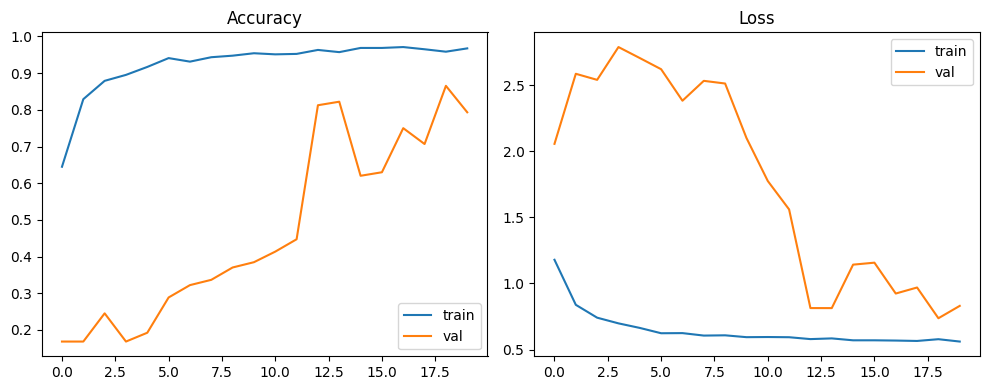

Test accuracy: 0.8461538461538461
                        precision    recall  f1-score   support

Yellow_Leaf_Curl_Virus       0.74      1.00      0.85        35
         black_measles       1.00      0.71      0.83        34
               healthy       0.94      0.89      0.91        35
            leaf_sorch       1.00      0.83      0.91        35
                mildew       0.65      1.00      0.79        34
                  scab       1.00      0.66      0.79        35

              accuracy                           0.85       208
             macro avg       0.89      0.85      0.85       208
          weighted avg       0.89      0.85      0.85       208



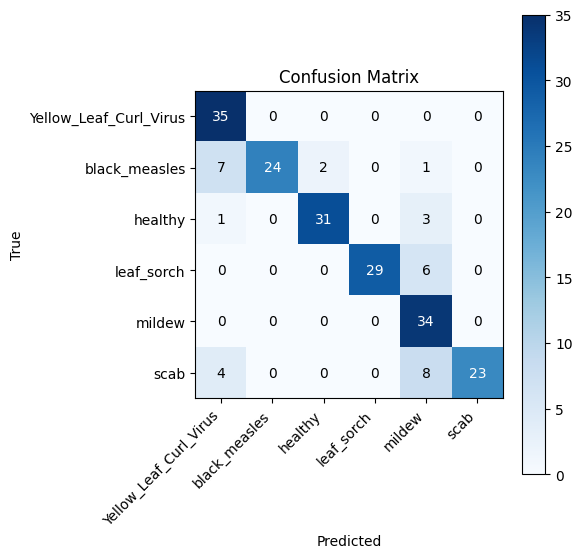

In [47]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history.history["accuracy"]); plt.plot(history.history["val_accuracy"]); plt.title("Accuracy"); plt.legend(["train","val"])
plt.subplot(1,2,2); plt.plot(history.history["loss"]); plt.plot(history.history["val_loss"]); plt.title("Loss"); plt.legend(["train","val"])
plt.tight_layout(); plt.show()

y_true = test_generator.classes
y_prob = model.predict(test_generator, verbose=0)
y_pred = y_prob.argmax(axis=1)

print("Test accuracy:", (y_true == y_pred).mean())
print(classification_report(y_true, y_pred, target_names=all_classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap='Blues'); plt.title('Confusion Matrix'); plt.colorbar()
ticks = np.arange(num_classes)
plt.xticks(ticks, all_classes, rotation=45, ha='right')
plt.yticks(ticks, all_classes)
thr = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], ha='center', va='center',
             color="white" if cm[i,j] > thr else "black")
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()

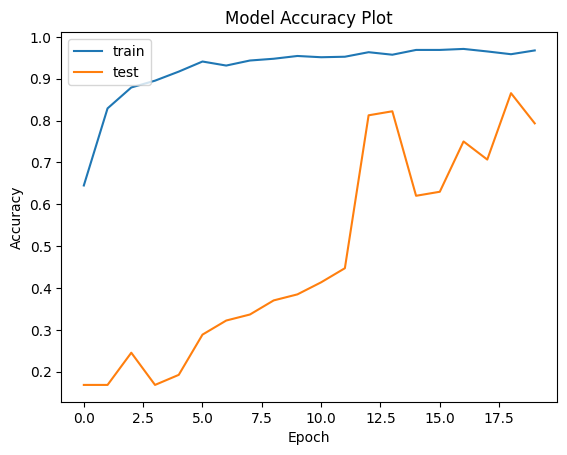

In [48]:
# Membuat plot dari histori akurasi model selama pelatihan dan validasi.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


## Konversi Model

In [49]:
best = keras.models.load_model("best.keras")
best.export("submission/saved_model")

Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  140072998507856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140072998510352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140072998513040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140072998507088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140072998513808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140073013046032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140072998513424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140072998507664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140073013043536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140072998514000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1400729

In [54]:
labels = [None] * len(class_indices)
for k, v in class_indices.items():
    labels[v] = k
print(labels)

['Yellow_Leaf_Curl_Virus', 'black_measles', 'healthy', 'leaf_sorch', 'mildew', 'scab']


In [55]:
best = keras.models.load_model("best.keras")

# Convert ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(best)


# Simpan file TFLite
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

with open("label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")


print("TFLite model berhasil dibuat!")

Saved artifact at '/tmp/tmp11gn832m'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  140072993594576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140072993593424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140072993589968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140072993591504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140072993587472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140072993593808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140072993588624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140072993591696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140072993590160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140072993594960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1400729935943

In [51]:
# Load Keras model
model = keras.models.load_model("best.keras")

# Convert the model to TensorFlow.js
tfjs.converters.save_keras_model(model, "path_to_save_tfjs_model")


failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

In [53]:
def predict_image(img_path, model, class_names, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Membuat prediksi
    predictions = model.predict(img_array)

    # Menentukan label dan probabilitas
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class = class_names[predicted_class_index]
    probability = predictions[0][predicted_class_index]

    return predicted_class, probability

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


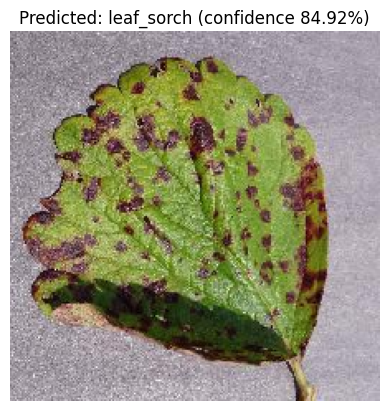

In [57]:
# Load model
best = keras.models.load_model("best.keras")

class_names = ['Yellow_Leaf_Curl_Virus', 'black_measles', 'healthy', 'leaf_sorch', 'mildew', 'scab']

# Path Image to predict
img_path = "/content/drive/MyDrive/plant leaf disease.v1i.multiclass/test/image-1027-_JPG.rf.1b97446a60e414877f7c1280cea04b4e.jpg"

# Make prediction
label, prob = predict_image(img_path, best, class_names, target_size=(IMG_SIZE, IMG_SIZE))

# Display the image and prediction
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
plt.imshow(img)
plt.title(f"Predicted: {label} (confidence {prob:.2%})")
plt.axis('off')
plt.show()

In [56]:
pip freeze > requirements.txt
